# 決定木 Decision Tree による要因探索とメトリック記録

製造工程データに決定木を適用し、説明変数・因子がどのように製造品の良品・不良品に影響しているかを分析します。最初は普通のScikit Learnを使用し決定木で学習します。Azure Machine Learning service のメトリック記録機能を使って、作業内容を記録することも示します。

# 学習データの準備

In [39]:
import pandas as pd
import os 

df = pd.read_csv('./data/Factory.csv')

In [41]:
df.tail(10)


ID  Quality  ProcessA-Pressure  ProcessA-Humidity  ProcessA-Vibration  \
4888  4889        0               6.80               0.22                0.36   
4889  4890        0               4.90               0.23                0.27   
4890  4891        0               6.10               0.34                0.29   
4891  4892        0               5.70               0.21                0.32   
4892  4893        0               6.50               0.23                0.38   
4893  4894        0               6.20               0.21                0.29   
4894  4895        0               6.60               0.32                0.36   
4895  4896        0               6.50               0.24                0.19   
4896  4897        1               5.50               0.29                0.30   
4897  4898        0               6.00               0.21                0.38   

      ProcessB-Light  ProcessB-Skill  ProcessB-Temp  ProcessB-Rotation  \
4888            1.20            0.05          38.00             127.00   
4889           11.75            0.03          34.00             118.00   
4890            2.20            0.04          25.00             100.00   
4891            0.90            0.04          38.00             121.00   
4892            1.30            0.03          29.00             112.00   
4893            1.60            0.04          24.00              92.00   
4894            8.00            0.05          57.00             168.00   
4895            1.20            0.04          30.00             111.00   
4896            1.10            0.02          20.00             110.00   
4897            0.80            0.02          22.00              98.00   

      ProcessC-Density  ProcessC-PH  ProcessC-skewness  ProcessC-Time  
4888              0.99         3.04               0.54           9.20  
4889              1.00         3.07               0.50           9.40  
4890              0.99         3.06               0.44          11.80  
4891              0.99         3.24               0.46          10.60  
4892              0.99         3.29               0.54           9.70  
4893              0.99         3.27               0.50          11.20  
4894              0.99         3.15               0.46           9.60  
4895              0.99         2.99               0.46           9.40  
4896              0.99         3.34               0.38          12.80  
4897              0.99         3.26               0.32          11.80

In [42]:
from sklearn.model_selection import train_test_split

X = df.drop(["Quality","ID"],axis=1)
y = df["Quality"].values
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=100,stratify=y)

# 決定木 Decision Tree による学習

In [47]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5, criterion='gini')
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
from sklearn.metrics import (roc_curve, auc, accuracy_score)

pred = clf.predict(X_test)
#fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
#auc(fpr, tpr)
print("モデル精度", accuracy_score(pred, y_test))

モデル精度 0.7979591836734694


In [49]:
!pip install pydotplus

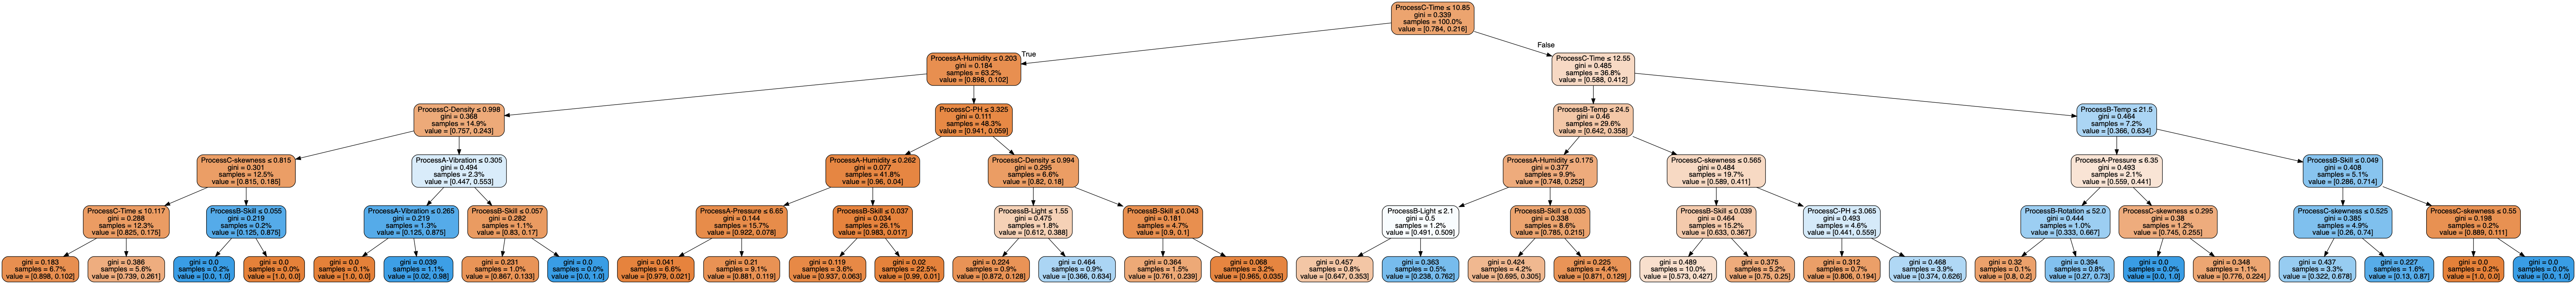

In [50]:
#import graphviz
import pydotplus as pdp
from IPython.display import Image

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, proportion=True, filled=True, rounded=True, special_characters=True)  
graph = pdp.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Azure Machine Learning service

Azure Machine Learning service の資産管理の仕組みを利用して、メトリック、データセット、モデルを保存します。

# 事前準備

### Python SDK インポート

In [51]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
import logging
import pydotplus as pdp

In [52]:
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.39


### Azure ML service ワークスペースとの接続

In [53]:
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

azureml	eastus	mlservice	eastus


### 実験 Expriment 設定

In [54]:
experiment=Experiment(ws, "Dllab-Artifact-DT")

### Dataset の登録とスナップショットの作成

In [12]:
# from azureml.core import Dataset
# from azureml.data.dataset_snapshot import DatasetSnapshot

# # Dataset 登録
# factory_dataset = Dataset.auto_read_files('./data/Factory.csv')
# dataset = factory_dataset.register(workspace = ws, name = 'factory_dataset', description = 'Factory.csv data',exist_ok = True)
# # Snapshot 作成
# snapshot = dataset.create_snapshot(snapshot_name = "factory_snapshot", compute_target = "local",create_data_snapshot = True)

### メトリック記録の開始

In [55]:
run = experiment.start_logging()

# 決定木 Decision Tree による学習

In [56]:
# ハイパーパラメータ
max_depth = 8
criterion = 'entropy' # 'entropy'  or 'gini'

In [57]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf = clf.fit(X_train, y_train)

In [58]:
from sklearn.metrics import (roc_curve, auc, accuracy_score)

pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
# モデル精度
print(accuracy)

0.7959183673469388


# メトリック記録

### ハイパーパラメータの記録

In [59]:
run.log("木の分割基準", criterion)
run.log("木の深さ", max_depth)
run.log("精度",accuracy)

### 画像イメージの記録

In [60]:
#import graphviz
import pydotplus as pdp

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, proportion=True, filled=True, rounded=True, special_characters=True)  
graph = pdp.graph_from_dot_data(dot_data)
graph.write_png("tree.png")

True

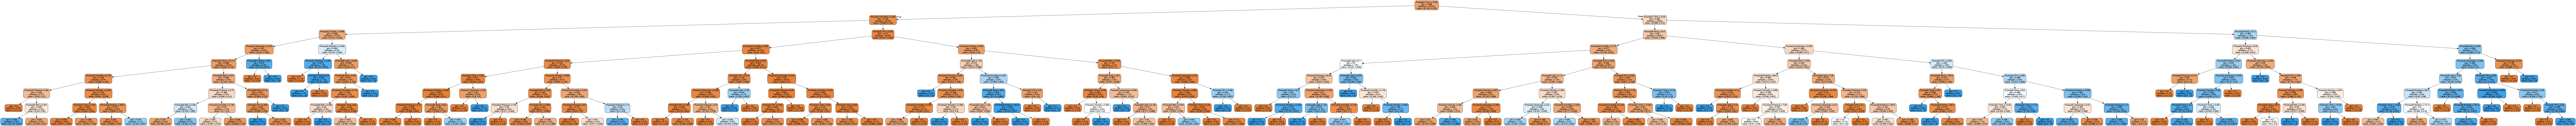

In [61]:
Image(graph.create_png())

In [62]:
run.log_image(name = "DT image", path="tree.png")

### モデルファイルのアップロード

In [63]:
import pickle
filename = 'DT-model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [64]:
run.upload_file(name= "outputs/"+filename, path_or_stream=filename)

### メトリック記録の完了

In [65]:
run.complete()

In [66]:
run.get_details()

{'runId': '77118794-d69b-4676-8c9f-7ff1ffca770a',
 'target': 'sdk',
 'status': 'Completed',
 'startTimeUtc': '2019-05-17T05:22:05.345541Z',
 'endTimeUtc': '2019-05-17T05:24:15.192934Z',
 'properties': {'azureml.git.repository_uri': None,
  'azureml.git.branch': None,
  'azureml.git.commit': None,
  'azureml.git.dirty': 'False',
  'azureml.git.build_id': None,
  'azureml.git.build_uri': None,
  'mlflow.source.git.branch': None,
  'mlflow.source.git.commit': None,
  'mlflow.source.git.repoURL': None,
  'ContentSnapshotId': 'f4c7c064-75de-4ae0-84e7-32543346a394'},
 'logFiles': {}}

In [67]:
run

Run(Experiment: Dllab-Artifact-DT,
Id: 77118794-d69b-4676-8c9f-7ff1ffca770a,
Type: None,
Status: Completed)

# モデル登録

In [68]:
from azureml.core.model import Model

model = run.register_model(model_name='DT-sklearn', 
                           model_path = 'outputs/' + filename,
                           tags = {'area': "decision tree by sklearn", 'type': "classification", 'run_id' : run.id}
                          )

In [69]:
print(model.name, model.version, model.tags)

DT-sklearn 7 {'area': 'decision tree by sklearn', 'type': 'classification', 'run_id': '77118794-d69b-4676-8c9f-7ff1ffca770a'}


# Webサービスとしてデプロイ

## モデル呼び出し

In [28]:
model=Model(ws, 'DT-sklearn')

## 推論用コード

In [29]:
%%writefile score_decisiontree.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('DT-sklearn')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict_proba(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Overwriting score_decisiontree.py


## パッケージ情報

In [30]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

## Dockerイメージ設定

In [31]:
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# 推論Dockerイメージの設定
image_config = ContainerImage.image_configuration(execution_script="score_decisiontree.py", runtime="python", conda_file="myenv.yml")

## Dockerイメージ作成

In [32]:
%%time
from azureml.core.image import Image,ContainerImage
image = Image.create(name = "sklearn-decisiontree-image", models = [model],image_config = image_config, workspace = ws)
image.wait_for_creation(show_output = True)

Creating image
Running..........................................
Succeeded
Image creation operation finished for image sklearn-decisiontree-image:3, operation "Succeeded"
CPU times: user 1.83 s, sys: 199 ms, total: 2.03 s
Wall time: 4min 28s


In [33]:
print(image.name, image.version, image.creation_state, image.image_location)

sklearn-decisiontree-image 3 Succeeded azuremla147cad7.azurecr.io/sklearn-decisiontree-image:3


In [34]:
%%time
from azureml.core.webservice import AciWebservice
import datetime

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, tags={'area': "decision tree", 'type': "classification"}, description='Decision Tree model from Quality Control')

service = Webservice.deploy_from_image(deployment_config=aciconfig,
                                        image=image,
                                        name="qc"+ datetime.datetime.now().strftime('%m%d%H%M'),
                                        workspace=ws)

service.wait_for_deployment(show_output=True)

Creating service
Running...................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 954 ms, sys: 112 ms, total: 1.07 s
Wall time: 2min 3s


## Webサービスのテスト

In [35]:
import requests
import numpy as np
scoring_uri = service.scoring_uri

In [36]:
# 入力データ
input_i = "5.5, 0.290, 0.30, 1.10, 0.022, 20.0, 110.0, 0.98869, 3.34, 0.38, 12.8"
input = np.array(input_i.split(","), dtype = np.float)

In [37]:
import json
test_sample = json.dumps({'data': [input.tolist()]})
test_sample = bytes(test_sample,encoding = 'utf8')
print(test_sample)

b'{"data": [[5.5, 0.29, 0.3, 1.1, 0.022, 20.0, 110.0, 0.98869, 3.34, 0.38, 12.8]]}'


In [38]:
headers = { 'Content-Type':'application/json' }
resp = requests.post(scoring_uri, test_sample, headers = headers)
print(resp.text)

[[0.3333333333333333, 0.6666666666666666]]
